### LSB index 
## AMIE manus period 

period : 1 Oct 2011 - 31 March 2012


In [1]:
import glob 
import pandas as pd

import xarray as xr

In [2]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np


from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=12,                     # Number of cores per task (adjust if needed)
    processes=6,                 # One process per task
    memory="100GB",               # --mem
    walltime="01:15:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)
client

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42493 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:42493/status,
Dashboard: http://10.42.239.61:42493/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:38919,Workers: 0
Dashboard: http://10.42.239.61:42493/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
era_data = glob.glob('/home1/nalex2023/Datasets/era5_manus/*.nc')
dft_era = pd.DataFrame(era_data, columns=['files'])


dft_era['year'] = dft_era['files'].str.split('_').str[-1].str[:4]
dft_era['month'] = dft_era['files'].str.split('_').str[-1].str[4:6].astype(int)



In [39]:
amie_period = pd.date_range(start='2011-10-01', end='2012-03-31', freq='D')

dft_era_amie = dft_era[(dft_era['year'].isin(amie_period.year.astype(str))) & (dft_era['month'].isin(amie_period.month))]


era_dset_amie = xr.open_mfdataset(dft_era_amie['files'].values, combine='by_coords').sel(pressure_level=slice(1000,800),latitude=slice(-1,-3),longitude=slice(146,148))



In [45]:

era_dset_amie_diurnal = era_dset_amie.groupby('valid_time.hour').mean().sel(pressure_level=1000).compute()

era_dset_amie_diurnal['u'] = era_dset_amie_diurnal['u'].roll(hour=10)
era_dset_amie_diurnal['v'] = era_dset_amie_diurnal['v'].roll(hour=10)

era_dset_amie_diurnal['speed'] = mpcalc.wind_speed(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)
era_dset_amie_diurnal['direction'] = mpcalc.wind_direction(era_dset_amie_diurnal.u,era_dset_amie_diurnal.v)



(<Figure size 2000x1000 with 48 Axes>,
 array([[<GeoAxes: title={'center': '12 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '1 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '2 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '3 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '4 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '5 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>],
        [<GeoAxes: title={'center': '6 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'center': '7 AM'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
         <GeoAxes: title={'cent

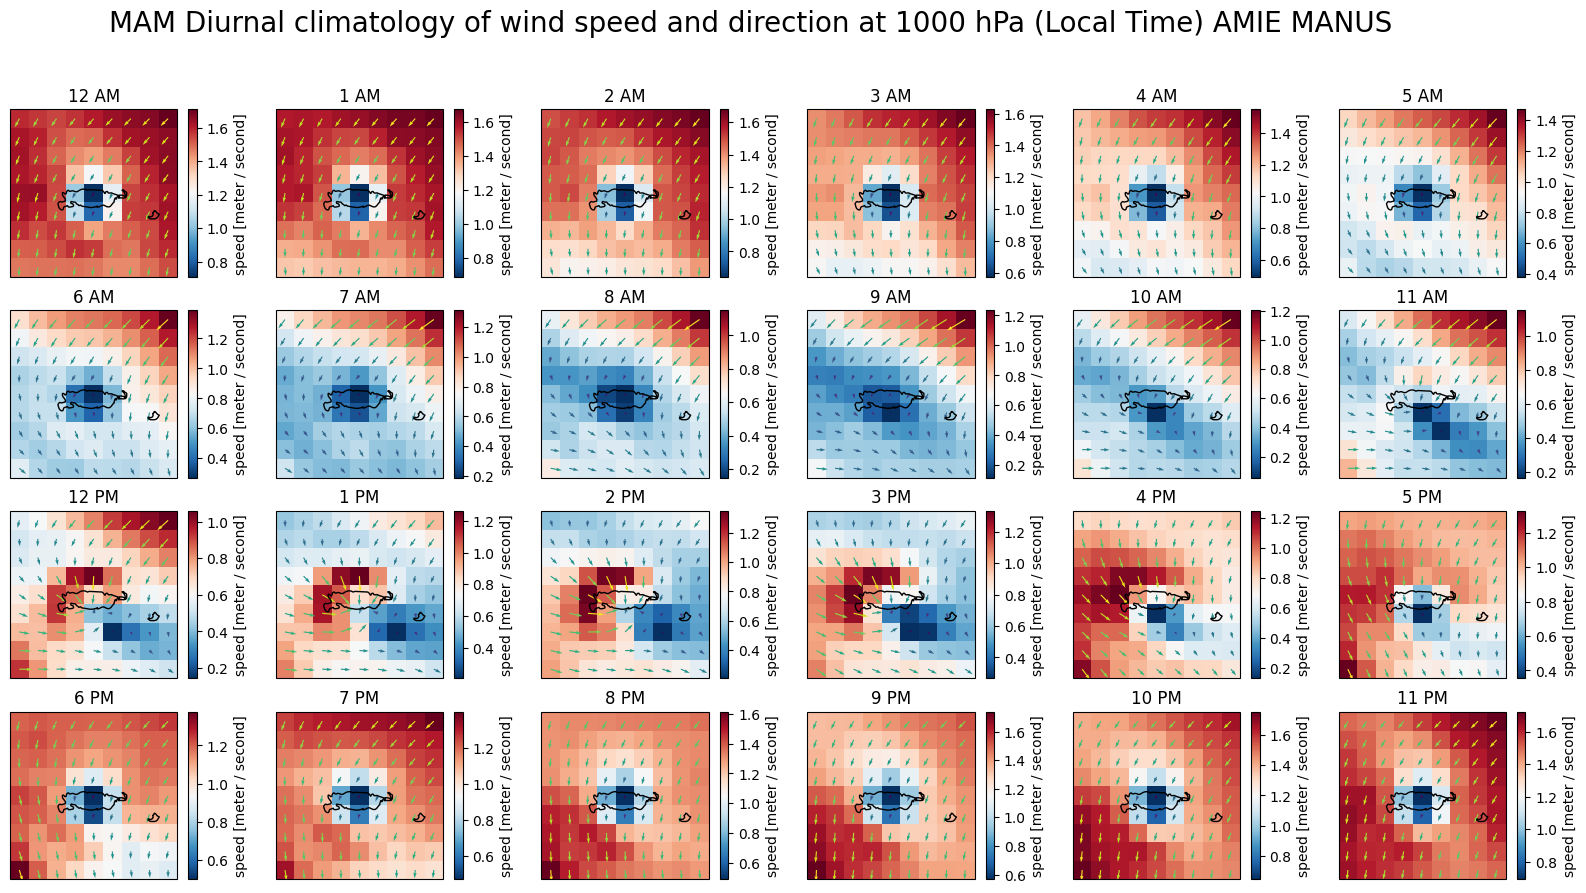

In [46]:

import metpy.calc as mpcalc
import numpy as np
import metpy.units as units
import cartopy.crs as ccrs



def create_spatial_quiver(era_data_diurnal):
    fig , ax = plt.subplots(4,6,subplot_kw={'projection':ccrs.PlateCarree()},figsize=(20,10))
    axs = ax.flatten()
    for i in range(24):
        x = era_data_diurnal.longitude
        y = era_data_diurnal.latitude
        z = era_data_diurnal.speed.sel(hour=i)
        c = era_data_diurnal.direction.sel(hour=i)
        u = era_data_diurnal.u.sel(hour=i)
        v = era_data_diurnal.v.sel(hour=i)
        era_data_diurnal.speed.sel(hour=i).plot(ax=axs[i],cmap='RdBu_r',transform=ccrs.PlateCarree())
        axs[i].quiver(x,y,u,v,z,transform=ccrs.PlateCarree())
        axs[i].coastlines()
        hour_in_ampm = i%12
        if hour_in_ampm == 0:
            hour_in_ampm = 12
        if i < 12:
            axs[i].set_title(f'{hour_in_ampm} AM')
        else:
            axs[i].set_title(f'{hour_in_ampm} PM')
    
    fig.suptitle('MAM Diurnal climatology of wind speed and direction at 1000 hPa (Local Time) AMIE MANUS',fontsize=20)

    return fig,ax


create_spatial_quiver(era_dset_amie_diurnal)


In [53]:
interp_data = '/home1/nalex2023/Datasets/interpsonde_manus/'

dft_interp = pd.DataFrame(glob.glob(interp_data+'*.nc'),columns=['files'])

dft_interp['year'] = dft_interp['files'].str.split(os.sep).str[-1].str.split('_').str[0]


dft_sub = dft_interp[dft_interp['year'].isin(amie_period.year.astype(str))]

dset_interp = xr.open_mfdataset(dft_sub['files'].values,combine='by_coords').compute()


Magnitude,[1.4226016998291016 1.2917877435684204 1.1609739065170288 ... 1.7983750104904175 1.8995431661605835 1.9631929397583008]
Units,meter/second


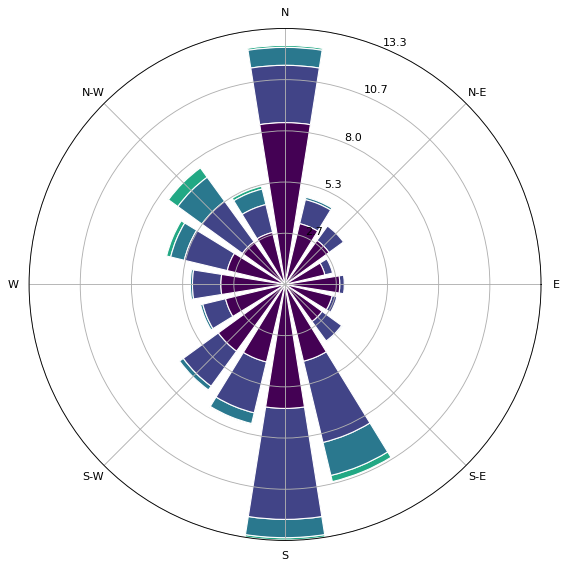

In [84]:
from windrose import WindroseAxes

wspd = mpcalc.wind_speed(dset_interp.u_wind,dset_interp.v_wind).sel(height=0,method='nearest').dropna('time').values

wdir = mpcalc.wind_direction(dset_interp.u_wind,dset_interp.v_wind).sel(height=0,method='nearest').dropna('time').values

ax = WindroseAxes.from_ax()

ax.bar(wdir,wspd, normed=True, opening=0.8, edgecolor='white')
# set xticks as the angles


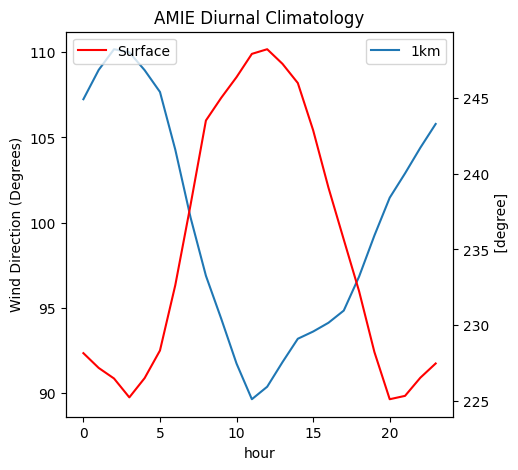

In [102]:

dset_interp_diurnal = dset_interp.groupby('time.hour').mean().compute()

wspd_diurnal1 = mpcalc.wind_speed(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=1,method='nearest')
wdir_diurnal1 = mpcalc.wind_direction(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=1,method='nearest')

wdir_diurnal0 = mpcalc.wind_direction(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=0,method='nearest')
wspd_diurnal0 = mpcalc.wind_speed(dset_interp_diurnal.u_wind,dset_interp_diurnal.v_wind).sel(height=0,method='nearest')

fig,ax = plt.subplots(figsize=(5,5))
wdir_diurnal1.plot(ax=ax,label='1km')

ax2 = ax.twinx()

wdir_diurnal0.plot(ax=ax2,color='red',label='Surface')

ax.set_ylabel('Wind Direction (Degrees)')

ax.set_title('AMIE Diurnal Climatology')

ax2.set_title('')
ax.legend()
ax2.legend(loc='upper left')



AttributeError: PathCollection.set() got an unexpected keyword argument 'normed'

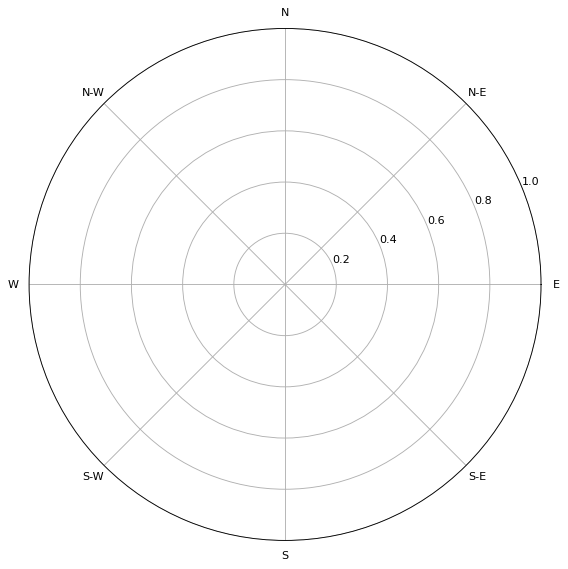

In [88]:
ax = WindroseAxes.from_ax()

ax.scatter(wdir_diurnal1,wspd_diurnal1, normed=True, edgecolor='white',color='red',label='1 km')